## GOAL:
Sightseeing Path Problem (city walk):
  - input(start_time, start_location, duration)
    - start_time and start_loaction will be input as a picture and translate to a location a time
  - generate the best sightseeing route based on the amenities and tourist locations nearby
  - Use OSRM to generate paths and duration between sightseeing location

## TODO

Decide tourist attractions
- Go through the ameneties and label/categorize tourist atrractions, and maybe other ameneties (like resterants etc)
- Add labels like museum, park, landmarks, architecture, entertainment, shopping,
- Remove unneeded locations (that aren't tourist attractions, or resteraunts)
- Create dataset with only foodplaces: resteraunt/cafe/pub/etc
- Remove NaNs and other invalid locations

Decide weighting
- Which amenity categories are more interesting or important?
- tourism tag, historic tag, wiki article or not?
- Weight heuristic


Create route
1. weight(score) each interest points (landmarks) to each amenity
2. Choose some endpoints(interest points) that are close to the start point
perhaps using some TSP algorithm for optimization and look for certain landmarks above a weight threshold (so no random benches)
3. Use that endpoint as the new start point and look for the next
4. decide on which path has the highest weight

starting point -> first neartest interest point -> second nearest interest point

Extra stuff
- Modifying weights for categories
- Optimizing route to prevent backtracking
- input preference for certain locations or amenity types
- suggest resteraunts by time like 9am 1pm, 8pm,

## Start
Run me every time!

Import Libraries

Downloading and parsing data into a dataframe.
  

In [ ]:
import requests
import numpy as np
import pandas as pd
import json
import random
import math
from matplotlib import pyplot as plt

In [ ]:
!wget -O amenities-vancouver.json.gz https://raw.githubusercontent.com/b0bhat/colab-data/main/amenities-vancouver.json.gz

--2024-03-29 01:26:24--  https://raw.githubusercontent.com/b0bhat/colab-data/main/amenities-vancouver.json.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 658247 (643K) [application/octet-stream]
Saving to: ‘amenities-vancouver.json.gz’

amenities-vancouver 100%[===================>] 642.82K  --.-KB/s    in 0.04s   

2024-03-29 01:26:24 (14.2 MB/s) - ‘amenities-vancouver.json.gz’ saved [658247/658247]



In [ ]:
# with the provided amenities-vancouver.json.gz
data = pd.read_json('./amenities-vancouver.json.gz', lines=True)

In [ ]:
['cafe' 'fast_food' 'toilets' 'bbq' 'place_of_worship' ''
 'telephone' 'fuel' 'vending_machine' 'restaurant' 'parking_entrance'
 'pub' 'bicycle_parking' 'school' 'bench' 'community_centre'
 'waste_basket' 'pharmacy' 'dentist' 'doctors' 'post_office' 'atm'
 'childcare' 'parking' 'public_building' 'bank' 'cinema' 'theatre'
 'ferry_terminal' 'bar' 'library' 'car_rental' 'drinking_water' 'shelter'
 'car_sharing' 'bicycle_rental' 'clinic' 'recycling' 'public_bookcase'
 'university' 'dojo' 'food_court' 'seaplane terminal' 'arts_centre'
 'ice_cream' 'charging_station' 'car_wash' 'fountain' 'veterinary'
 'bicycle_repair_station' 'waste_disposal' 'photo_booth' 'luggage_locker'
 'bureau_de_change' 'parking_space' 'nightclub' 'social_facility' 'taxi'
 'bus_station' 'college' 'construction' 'post_depot' 'nursery' 'clock'
 'kindergarten' 'conference_centre' 'shower' 'marketplace' 'hospital'
 'trolley_bay' 'fire_station' 'police' 'motorcycle_parking' 'stripclub'
 'gambling' 'compressed_air' 'family_centre' 'townhall' 'music_school'
 'bistro' 'playground' 'boat_rental' 'meditation_centre' 'spa' 'scrapyard'
 'language_school' 'courthouse' 'events_venue' 'prep_school' 'healthcare'
 'cram_school' 'science' 'ATLAS_clean_room' 'workshop' 'safety' 'lobby'
 'animal_shelter' 'juice_bar' 'internet_cafe' 'social_centre'
 'vacuum_cleaner' 'smoking_area' 'EVSE' 'studio' 'first_aid'
 'ranger_station' 'storage_rental' 'watering_place' 'lounge' 'trash'
 'sanitary_dump_station' 'disused:restaurant' 'water_point'
 'Observation Platform' 'housing co-op' 'driving_school' 'loading_dock'
 'chiropractor' 'monastery' 'storage' 'gym' 'payment_terminal' 'atm;bank'
 'park' 'biergarten' 'casino' 'Pharmacy' 'waste_transfer_station'
 'office|financial' 'hunting_stand' 'money_transfer' 'shop|clothes'
 'letter_box' 'training' 'car_rep' 'research_institute'
 'motorcycle_rental' 'leisure']

['cafefast_foodtoiletsbbqplace_of_worshiptelephonefuelvending_machinerestaurantparking_entrancepubbicycle_parkingschoolbenchcommunity_centrewaste_basketpharmacydentistdoctorspost_officeatmchildcareparkingpublic_buildingbankcinematheatreferry_terminalbarlibrarycar_rentaldrinking_watersheltercar_sharingbicycle_rentalclinicrecyclingpublic_bookcaseuniversitydojofood_courtseaplane terminalarts_centreice_creamcharging_stationcar_washfountainveterinarybicycle_repair_stationwaste_disposalphoto_boothluggage_lockerbureau_de_changeparking_spacenightclubsocial_facilitytaxibus_stationcollegeconstructionpost_depotnurseryclockkindergartenconference_centreshowermarketplacehospitaltrolley_bayfire_stationpolicemotorcycle_parkingstripclubgamblingcompressed_airfamily_centretownhallmusic_schoolbistroplaygroundboat_rentalmeditation_centrespascrapyardlanguage_schoolcourthouseevents_venueprep_schoolhealthcarecram_schoolscienceATLAS_clean_roomworkshopsafetylobbyanimal_shelterjuice_barinternet_cafesocial_centre

## Cleaning the Data Sets:
- remove uneccessary amentity types, for example, bench, washroom, etc.
- fix amentities by tag or knowledge, for example
  - we all know that the gas town steam clock is a tourist attraction point, but its amentity is `clock` in the data set, change it to `tourist_attraction`

In [ ]:
amenities_not_include = [
    "toilets", "place_of_worship", "post_box", "telephone", "school", "bench", "community_centre",
    "waste_basket", "pharmacy", "dentist", "doctors", "post_office", "childcare", "clinic", "recycling",
    "public_bookcase", "university", "dojo", "veterinary", "bicycle_repair_station", "waste_disposal",
    "social_facility", "college", "construction", "post_depot", "nursery", "kindergarten", "conference_centre",
    "shower", "hospital", "trolley_bay", "fire_station", "police", "compressed_air", "family_centre",
    "music_school", "meditation_centre", "scrapyard", "language_school", "courthouse", "prep_school", "healthcare",
    "cram_school", "science", "ATLAS_clean_room", "workshop", "safety", "lobby", "animal_shelter",
    "vacuum_cleaner", "studio", "first_aid", "ranger_station", "storage_rental", "trash", "sanitary_dump_station",
    "housing co-op", "driving_school", "loading_dock", "chiropractor", "monastery", "storage", "payment_terminal",
    "Pharmacy", "waste_transfer_station", "office|financial", "letter_box", "training", "research_institute",
    "fuel", "parking", "parking_entrance", "bicycle_parking", "public_building", "bank", "shelter",
    "car_sharing", "drinking_water", "vending_machine", "parking", "ferry_terminal", "atm", "car_rental",
    "car_wash", "charging_station", "bicycle_rental", "seaplane terminal", "luggage_locker", "bureau_de_change",
    "taxi", "bus_station", "stripclub", "spa", "motorcycle_parking", "water_point", "boat_rental", "smoking_area",
    "EVSE", "car_rep", "watering_place", "lounge", "parking_space", "gym", "atm;bank", "hunting_stand", "money_transfer",
    "motorcycle_rental"
    ]

In [ ]:
# interesting places, but probably low weight?
low_weight = [
    "nightclub", "townhall", "theatre", "library", "arts_centre", "cinema", "playground", "photo_booth",
    "fountain", "marketplace", "gambling", "social_centre", "events_venue", "clock"
]

In [ ]:
# food
food = [
    "restaurant", "bistro", "fast_food", "bar", "pub", "cafe", "ice_cream", "food_court", "bbq",
    "disused:restaurant", "juice_bar", "internet_cafe", "biergarten",
]

In [ ]:
# Function to check if a tags has 'historic' or 'tourism' keys
def has_tourism(tags):
    return 'tourism' in tags

# all records that have tourism key in their tag
tourism_data = data[data['tags'].apply(has_tourism)]

# remove records in the filtered_data that has 'bench' or 'Trans Canada Trail Pavillion' in the 'name' column
tourism_data = tourism_data[tourism_data['amenity'] != 'bench']
tourism_data = tourism_data[tourism_data['name'] != 'Trans Canada Trail Pavillion']

# for record in the filtered_data, change its 'amenity' column to 'tourism' and update the main data
data.loc[tourism_data.index, 'amenity'] = 'tourism'

# list with amenities to include
# amenities_include = set(data['amenity'].unique()) - set(amenities_not_include)  - set(food)
amenities_include = set(data['amenity'].unique()) - set(amenities_not_include)
amenities_food = set(data['amenity'].unique())

# keep records in data that if the 'amenity' column is in the amenities_include list
food_data = data[data['amenity'].isin(amenities_include)]
data = data[data['amenity'].isin(amenities_include)]
data.to_csv('amenities-vancouver-included.csv', index=False)

## Weighting the amenity
1. decide base weight for unique amenities

In [ ]:
data['amenity'].unique()

array(['cafe', 'fast_food', 'bbq', 'restaurant', 'pub', 'cinema',
       'theatre', 'bar', 'library', 'food_court', 'arts_centre',
       'ice_cream', 'fountain', 'photo_booth', 'nightclub', 'tourism',
       'marketplace', 'clock', 'gambling', 'townhall', 'bistro',
       'playground', 'events_venue', 'juice_bar', 'internet_cafe',
       'social_centre', 'disused:restaurant', 'Observation Platform',
       'park', 'biergarten', 'casino', 'leisure'], dtype=object)

In [ ]:
adult_only_amenities = ['bar','pub','nightclub', 'gambling', 'casino']

# assign manually the base weight to different amenity from range (1-10)
base_weights = {
    "cafe": 3,
    "fast_food": 2,
    "bbq": 3,
    "restaurant": 6,
    "pub": 5,    # familty mode
    "cinema": 5,
    "theatre": 5,
    "bar": 6,    # familty mode
    "library": 2,
    "fountain": 1,
    "photo_booth": 4,
    "nightclub": 5,    # familty mode
    "tourism": 10,
    "marketplace": 9,
    "clock": 1,
    "gambling": 6,    # familty mode
    "townhall": 2,
    "bistro": 5,
    "playground": 4,
    "events_venue": 6,
    "juice_bar": 3,
    "internet_cafe": 3,
    "social_centre": 3,
    "disused:restaurant": 6,
    "Observation Platform": 8,
    "park": 5,
    "biergarten": 5,    # familty mode
    "casino": 5,    # familty mode
    "leisure": 5,
    "shop|clothes": 7}

# map the dictionary to the dataset
data['weight'] = data['amenity'].map(base_weights)

,lat,lon,timestamp,amenity,name,tags,weight
10385,49.325315,-123.124771,2019-05-02T13:27:49.000-07:00,disused:restaurant,Earls,{},0.0


## Image Processing (extract metedata from a input picture)
Will use the pillow python module

In [ ]:
!pip install pillow-heif

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 20.0 MB/s eta 0:00:00
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 441, in run
    conflicts = self._determi

In [ ]:
import os
from PIL import Image
from PIL.ExifTags import TAGS, GPSTAGS
from pillow_heif import register_heif_opener

ModuleNotFoundError: No module named 'pillow_heif'

In [ ]:
# reference: https://www.geeksforgeeks.org/how-to-extract-image-metadata-in-python/
def get_metadata(image_file):
  if image_file.endswith(".jpg") or image_file.endswith(".JPG") or image_file.endswith(".jpeg"):
    image = Image.open(image_file)
  elif image_file.endswith(".HEIC"):
    register_heif_opener()
    image = Image.open(image_file)

  # extract exif metadata
  exif_data = {}
  exif_info = image._getexif()

  if not exif_info:
    return None

  for tag, value in exif_info.items():
    decoded = TAGS.get(tag, tag)
    if decoded == "GPSInfo":
      gps_data = {}
      for gps_tag in value:
          sub_decoded = GPSTAGS.get(gps_tag, gps_tag)
          gps_data[sub_decoded] = value[gps_tag]
      exif_data[decoded] = gps_data
    else:
      exif_data[decoded] = value

  return exif_data

# reference: https://stackoverflow.com/questions/19804768/interpreting-gps-info-of-exif-data-from-photo-in-python
def gps_data_to_degree(degrees, minutes, seconds, direction):
  decimal = degrees + minutes / 60 + seconds / 3600
  if direction in ['S', 'W']:
      decimal = -decimal

  print(decimal)
  return decimal

In [ ]:
img_file = "./drive/MyDrive/cmpt353/20240317_145146.jpg"
img_file_local = "./kdu4ce.jpg"
metadata = get_metadata(img_file_local)
print(metadata['GPSInfo'])
latitude = gps_data_to_degree(*metadata['GPSInfo']['GPSLatitude'], metadata['GPSInfo']['GPSLatitudeRef'])
longitude = gps_data_to_degree(*metadata['GPSInfo']['GPSLongitude'], metadata['GPSInfo']['GPSLongitudeRef'])
location = (longitude, latitude)
location

## Geo Coding: Translating Addresses into latitude and longtitude
This can translate text addresses into geographic data -> this will be use for the start location and end location
- start location as image
  - do some image processing to get name or address that we can geo code into lat and lon
- end location will be text so can be directly use in geo coding

In [ ]:
# https://nominatim.org/release-docs/develop/api/Search/
def geo_coding(address):
    base_url = f"https://nominatim.openstreetmap.org/search?"
    params = {
        "q": address,
        "format": "json"
    }
    headers = {
        "User-Agent": "cmpt353project"
    }
    response = requests.get(base_url, params=params, headers=headers)
    if response.status_code == 200: # successful
      result   = response.json()
      latitude  = result[0]['lat']
      longitude = result[0]['lon']
    else:
      print(f"[ERROR]: api call failed with code {response.status_code}")
      return None

    return (float(longitude), float(latitude))

geo_coding("1689 Johnston St, Vancouver, BC V6H 3R9")

(-123.13527422182382, 49.27273135)

## Route Generation

Using lat and lon to send GET request via http to OSRM, which returns route data in geojson.

Need to parse returned route for distance, and then for display as gpx?


In [ ]:
# https://project-osrm.org/docs/v5.5.1/api/#general-options
def osrm_route_query(coordinates, mode='driving'):
    base_url = f"http://router.project-osrm.org/route/v1/{mode}/"
    coordinates_str = ";".join([",".join(map(str, coord)) for coord in coordinates])
    query_params = {
        "steps": "true",
        "geometries": "geojson",
        "overview": "full"
    }
    response = requests.get(base_url + coordinates_str, params=query_params)
    return response.json()

start_point = (-73.98568, 40.748817)
end_point = (-73.98739, 40.764352)


route_data = osrm_route_query([start_point, end_point], mode="driving")
print(route_data)

{'code': 'Ok', 'routes': [{'geometry': {'coordinates': [[-73.985624, 40.748892], [-73.985047, 40.748645], [-73.984692, 40.748493], [-73.984557, 40.748436], [-73.984446, 40.748389], [-73.983451, 40.747973], [-73.98305, 40.747807], [-73.982962, 40.747769], [-73.982902, 40.747849], [-73.982544, 40.748335], [-73.982513, 40.748378], [-73.982478, 40.74843], [-73.982432, 40.748493], [-73.982068, 40.748991], [-73.982022, 40.749054], [-73.981973, 40.749119], [-73.981615, 40.749604], [-73.98157, 40.749665], [-73.981523, 40.74973], [-73.981193, 40.750187], [-73.981162, 40.75023], [-73.981123, 40.750283], [-73.981075, 40.750351], [-73.980722, 40.750848], [-73.980677, 40.750907], [-73.980629, 40.750971], [-73.980318, 40.751404], [-73.980272, 40.751469], [-73.980226, 40.751529], [-73.980188, 40.751581], [-73.979856, 40.752035], [-73.979819, 40.752085], [-73.979779, 40.75214], [-73.979735, 40.752201], [-73.979361, 40.752712], [-73.979287, 40.752813], [-73.979219, 40.752903], [-73.978939, 40.75327], [

## Visually Presenting the Route
- in the form of gpx file with https://www.mygpsfiles.com/app/
- other tools

In [ ]:
# from exercise3 calc_distance_hint.py
def output_gpx(points, output_filename):
    """
    Output a GPX file with latitude and longitude from the points DataFrame.
    """
    from xml.dom.minidom import getDOMImplementation
    def append_trkpt(pt, trkseg, doc):
        trkpt = doc.createElement('trkpt')
        trkpt.setAttribute('lat', '%.8f' % (pt['lat']))
        trkpt.setAttribute('lon', '%.8f' % (pt['lon']))
        trkseg.appendChild(trkpt)

    doc = getDOMImplementation().createDocument(None, 'gpx', None)
    trk = doc.createElement('trk')
    doc.documentElement.appendChild(trk)
    trkseg = doc.createElement('trkseg')
    trk.appendChild(trkseg)

    points.apply(append_trkpt, axis=1, trkseg=trkseg, doc=doc)

    with open(output_filename, 'w') as fh:
        doc.writexml(fh, indent=' ')

## Test: Given start address and End address, generate a route
Start address: SFU Burnaby, end address: UBC

In [ ]:
# given a image, extract its location
img_file_local = "./kdu4ce.jpeg"
metadata = get_metadata(img_file_local)
latitude = gps_data_to_degree(*metadata['GPSInfo']['GPSLatitude'], metadata['GPSInfo']['GPSLatitudeRef'])
longitude = gps_data_to_degree(*metadata['GPSInfo']['GPSLongitude'], metadata['GPSInfo']['GPSLongitudeRef'])
start_point = (longitude, latitude)
start_point
# start_point = (-100183637/1000000, 140628370679/3600000000)

# get location for text address
end = "6200 University Blvd, Vancouver, BC V6T 1Z3"
end_point = geo_coding(end)
end_point

# # generate route with OSRM
# route_data = osrm_route_query((start_point, end_point), mode='driving')
# route = route_data['routes'][0]['geometry']['coordinates']
# route_df = pd.DataFrame(route, columns=['lon', 'lat']) # the output_gpx take pandas dataframe
# route_df

NameError: name 'get_metadata' is not defined

In [ ]:
output_gpx(route_df, "test_iamge_processing.gpx")

## Algorithm to find closest point

In [ ]:
#@markdown #Settings to Generate Route (not implemented yet)
#@markdown Photo filename and location
image_file = "photo.png" #@param {type:"string"}
#@markdown If coordinates cannot be found, please enter address instead:
backup_address = "6200 University Blvd, Vancouver, BC V6T 1Z3" #@param {type:"string"}
#@markdown Approx desired duration of trip (hours)
duration = 6 #@param {type:"number"}
#@markdown other weight settings...


from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from geopy.distance import geodesic
from sklearn.neighbors import BallTree

In [ ]:
# randomly assign weights just for testing, 1 is lame and 10 is cool
probabilities = np.linspace(10, 1, num=10) / np.sum(np.linspace(10, 1, num=10))
random_values = np.random.choice(np.arange(1, 11), size=len(data), p=probabilities)
data_weighted = data.assign(weight=random_values)
print(data_weighted)
data_weighted.reset_index(drop=True, inplace=True)
print(data_weighted["weight"].value_counts().sort_index())

             lat         lon                      timestamp      amenity  \
73     49.281998 -123.124346  2019-03-22T02:51:06.000-07:00       cinema   
74     49.280504 -123.106872  2019-12-01T04:03:46.000-08:00      theatre   
92     49.219594 -123.066849  2019-09-02T22:08:25.000-07:00      library   
193    49.186068 -122.943529  2020-01-09T02:48:51.000-08:00      library   
299    49.285387 -122.790959  2019-09-13T13:56:49.000-07:00  arts_centre   
...          ...         ...                            ...          ...   
17462  49.133635 -123.091834  2019-06-06T07:24:12.000-07:00     fountain   
17662  49.243200 -122.972475  2020-03-19T17:53:47.000-07:00     townhall   
17663  49.191325 -122.849269  2020-03-19T18:04:53.000-07:00     townhall   
17693  49.252447 -122.736873  2020-03-31T00:14:11.000-07:00     fountain   
17694  49.251870 -122.737161  2020-03-31T00:14:11.000-07:00     fountain   

                                               name  \
73                     Scotiaban

In [ ]:
# need to take weight into account when finding nearest point
def find_closest_points(tree, p_lat, p_lon, k=10, epsilon=0.001):
    p_lat += np.random.uniform(-epsilon, epsilon)
    p_lon += np.random.uniform(-epsilon, epsilon)
    dist, index = tree.query([(p_lat, p_lon)], k=k)
    return index[0], dist[0]

def calculate_route(data, starting_point_index, max_points=10, max_distance=0.5):
    indices = [starting_point_index]
    total_distance = 0
    total_weight = 0
    balltree = BallTree(data[['lat', 'lon']].values, leaf_size = 15, metric='haversine')
    visited = set([starting_point_index])

    for _ in range(max_points):
      current_point = data.loc[indices[-1]]
      neighbors, distances = find_closest_points(balltree, current_point['lat'], current_point['lon'], k=max_points)
      adjusted_distances = []

      for neighbor, distance in zip(neighbors, distances):
        weight = neighbor.loc[neighbor]['weight']
        distance *= (1-(weight-1)/20)
        adjusted_distances.append(distance)

      adjusted_distances.sort()

      # get a list of neighbors and if a neighbor is not in the list, use it as the next point
      for neighbor, distance in zip(neighbors, adjusted_distances):
        if neighbor not in visited:
            total_distance += distance
            total_weight += data.loc[neighbor]['weight']
            indices.append(neighbor)
            visited.add(neighbor)
            break
      if total_distance >= max_distance:
        break

    # accounts for weighting
    # for _ in range(max_points):
    #   current_point = data.loc[indices[-1]]
    #   neighbors, distances = find_closest_points(balltree, current_point['lat'], current_point['lon'], k=max_points)
    #   # get a list of neighbors and if a neighbor is not in the list, use it as the next point
    #   max_weight = 0
    #   max_neighbor = 0
    #   max_neighbor_distance = 0
    #   for neighbor, distance in zip(neighbors, distances):
    #     if neighbor not in visited:
    #       weight = data.loc[neighbor]['weight']
    #       if weight > max_weight:
    #           max_weight = weight
    #           max_neighbor = neighbor
    #           max_neighbor_distance = distance

    #   total_distance += max_neighbor_distance
    #   total_weight += max_weight
    #   indices.append(max_neighbor)
    #   visited.add(max_neighbor)
    #   if total_distance >= max_distance:
    #     break

    return data.loc[indices], total_distance, total_weight

# Pick some point as starting location
test_point_index = data_weighted.index[100]

# calculate_route <weighed data> <your test point> <max points in route> <max km in route>
route, total_distance, total_weight = calculate_route(data_weighted, test_point_index, 100, 2)
print(total_distance, total_weight)


0.7358955184500425 399


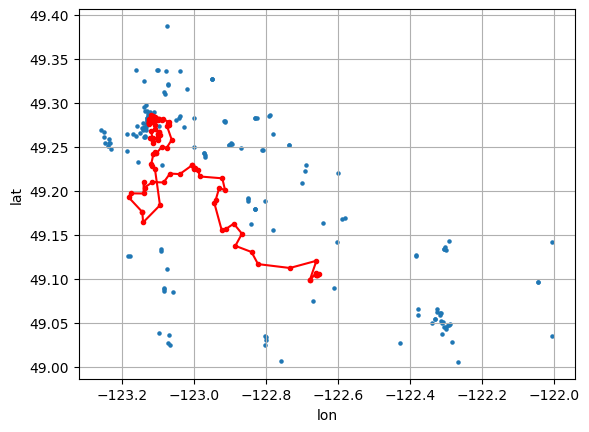

In [ ]:
plt.scatter(data_weighted['lon'], data_weighted['lat'], s=5)
route_lat = route['lat'].tolist()
route_lon = route['lon'].tolist()
plt.plot(route_lon, route_lat, marker='o', color='r', linestyle='-', markersize=3)
plt.xlabel('lon')
plt.ylabel('lat')
plt.grid(True)
plt.show()

In [ ]:
def stitch_route(route):
    stitched_route = pd.DataFrame(columns=['lon', 'lat'])
    for i in range(len(route) - 1):
        point1 = (route.iloc[i]['lon'], route.iloc[i]['lat'])
        point2 = (route.iloc[i+1]['lon'], route.iloc[i+1]['lat'])
        route_raw = osrm_route_query([point1, point2])
        route_coords = route_raw['routes'][0]['geometry']['coordinates']
        route_df = pd.DataFrame(route_coords, columns=['lon', 'lat'])
        stitched_route = pd.concat([stitched_route, route_df], ignore_index=True)

    return stitched_route

stitched_route = stitch_route(route)
output_gpx(stitched_route, "test_image_processing.gpx")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


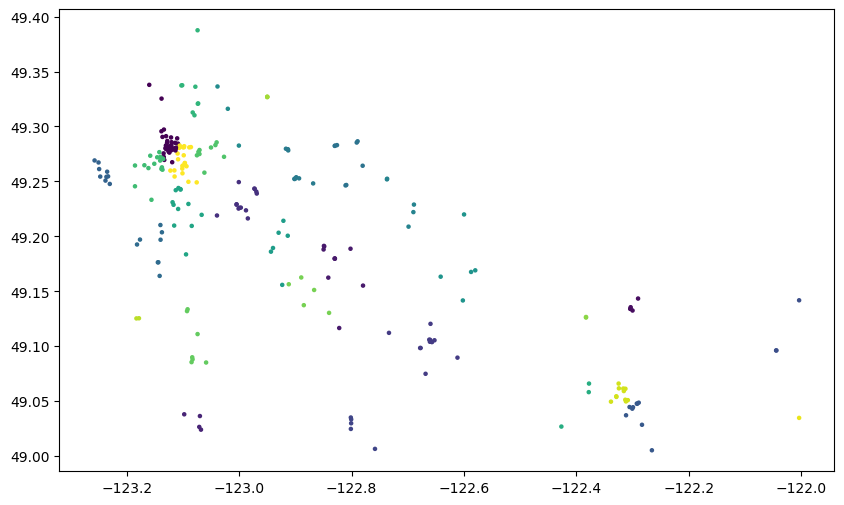

In [ ]:
X = data_weighted[['lat', 'lon']].values
num_clusters = 30
kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(X)
cluster_counts = pd.Series(kmeans.labels_).value_counts()

plt.figure(figsize=(10, 6))
plt.scatter(data['lon'], data['lat'], c=data['cluster'], s=5)
plt.show()